## Burger's equation: Two-step Method

In [1]:
import sys
#sys.path.append('/Users/josorior/Documents/UW/research/keql/KEQL/source')
#sys.path.append('/Users/yasaminjalalian/Repos/KEQL/source')
sys.path.append('/home/juanfelipe/Desktop/research/keql/source')

In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import * 
from models import *
from data_loader_Burgers2 import * 

import matplotlib.tri as tri
import matplotlib.pyplot as plt

from jax.config import config; 
config.update("jax_enable_x64", True)

(100, 320)


In [3]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [4]:
# 2-step dictionary
keys = ['optim_sgm_u','optim_nugget_u','rkhs_u','optim_sgm_P','optim_nugget_P','nugget_P', 'rkhs_P_train', 'rkhs_P_train', 'f_pred_test']
two_step_dict = dict.fromkeys(keys)

### Solution: Two-Step Method

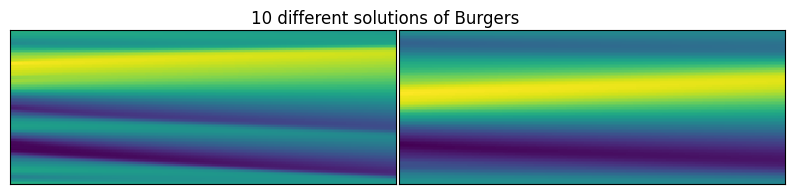

In [5]:
# u values in full grid of m functions
fig, axs = plt.subplots(figsize = (10,2), nrows = 1, ncols = m, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.01, wspace=0.01)
fig.suptitle('10 different solutions of Burgers')
axs = axs.ravel()
for i in range(m): 
    axs[i].pcolormesh(t, x, U[i])
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])

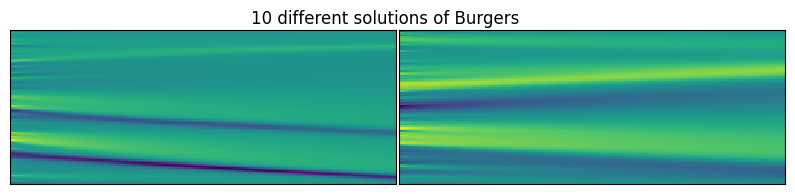

In [6]:
# u_t values in full grid of m functions
fig, axs = plt.subplots(figsize = (10,2), nrows = 1, ncols = m, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.01, wspace=0.01)
fig.suptitle('10 different solutions of Burgers')
axs = axs.ravel()
for i in range(m): 
    axs[i].pcolormesh(t, x, U_t[i])
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])

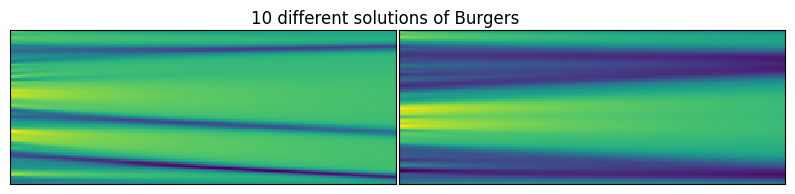

In [7]:
# u_x values in full grid of m functions
fig, axs = plt.subplots(figsize = (10,2), nrows = 1, ncols = m, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.01, wspace=0.01)
fig.suptitle('10 different solutions of Burgers')
axs = axs.ravel()
for i in range(m): 
    axs[i].pcolormesh(t, x, U_x[i])
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])

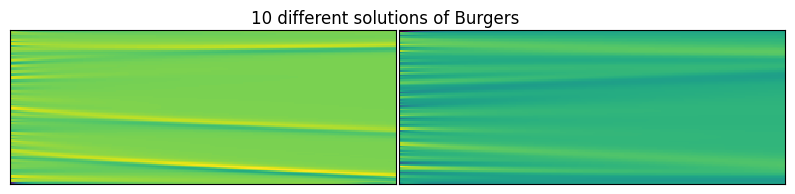

In [8]:
# u_xx values in full grid of m functions
fig, axs = plt.subplots(figsize = (10,2), nrows = 1, ncols = m, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.01, wspace=0.01)
fig.suptitle('10 different solutions of Burgers')
axs = axs.ravel()
for i in range(m): 
    axs[i].pcolormesh(t, x, U_xx[i])
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])

### > Step 1: Learning $u's$

In [9]:
print(U_train.shape)

(100, 2)


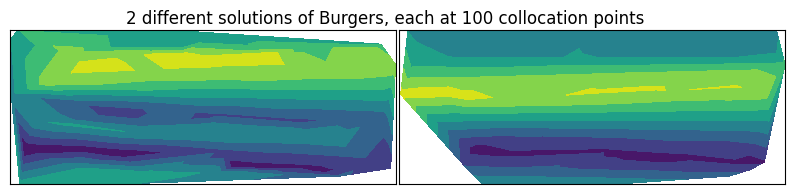

In [10]:
# u values at collocation points of m functions
fig, axs = plt.subplots(figsize = (10,2), nrows = 1, ncols = m, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.01, wspace=0.01)
fig.suptitle('{} different solutions of Burgers, each at {} collocation points'.format(m, N_train))
axs = axs.ravel()
for i in range(m):
    axs[i].tricontourf(X_train[i*N_train:(i+1)*N_train,0], X_train[i*N_train:(i+1)*N_train,1], U_train[:,i])
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])

In [11]:
# Learn alphas and lenght scale
optim_sgm_u, alphas, optim_nugget_u = kernel_parameters_Gaussian_2D(X_train, U_train, N_train)

In [12]:
# Save true values to be used in one-step
two_step_dict['optim_sgm_u'] = optim_sgm_u 
two_step_dict['optim_nugget_u'] = optim_nugget_u 
optim_sgm_u, optim_nugget_u

(array([1.97909948, 1.95091316]), array([1.e-08, 1.e-08]))

In [13]:
i = 1
jnp.dot(K_2D(Gaussian2D, X_test[i*N_test:(i+1)*N_test,:], X_train[i*N_train:(i+1)*N_train,:], optim_sgm_u[i]), alphas[:,i]).shape

(200,)

In [14]:
alphas[:,i].shape

(100,)

In [15]:
m = len(optim_sgm_u)
u_pred = np.zeros((N_train,m))

In [16]:
i = 1
u_pred[:,i] = jnp.dot(K_2D(Gaussian2D, X_train[i*N_train:(i+1)*N_train,:], X_train[i*N_train:(i+1)*N_train,:], optim_sgm_u[i]), alphas[:,i])

In [17]:
# Predict using interpolant and get its gradients
u_pred_train, u_t_pred_train, u_x_pred_train, u_xx_pred_train = predictions_Burgers(X_train, X_train, Gaussian2D, optim_sgm_u, alphas, N_train, N_test)
u_pred_test, u_t_pred_test, u_x_pred_test, u_xx_pred_test = predictions_Burgers(X_test,  X_train, Gaussian2D, optim_sgm_u, alphas, N_train, N_test)

In [10]:
# Save true values to warm up the onepfive method
np.save('data/u_pred_train.npy', u_pred_train)
np.save('data/u_pred_test.npy', u_pred_test)
# Save true gradients for comparing later  
np.save('data/u_t_train.npy',u_t_train) 
np.save('data/u_x_train.npy',u_x_train) 
np.save('data/u_xx_train.npy',u_xx_train) 
# Save gradients for one step method
np.save('data/u_x_pred_train.npy',u_x_pred_train)
np.save('data/u_xx_pred_train.npy',u_xx_pred_train)
np.save('data/u_x_pred_test.npy',u_x_pred_test)
np.save('data/u_xx_pred_test.npy',u_xx_pred_test)

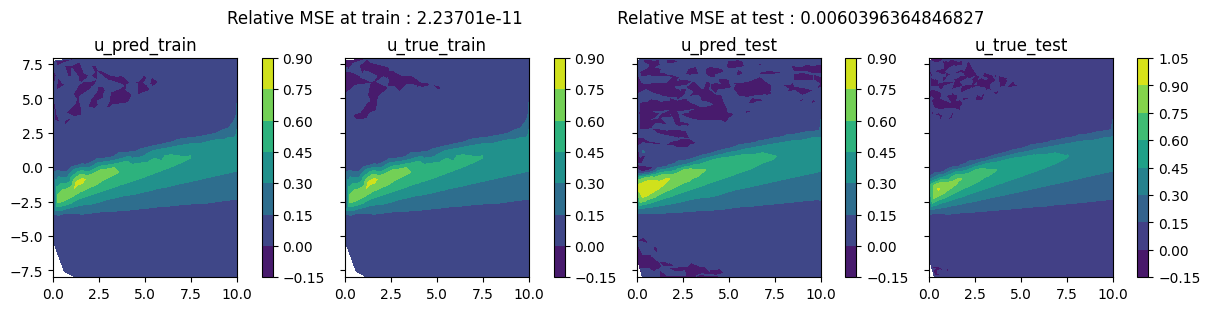

In [11]:
# u at training points and testing points
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 1, ncols=4 ,sharey= True, figsize = (12,3),constrained_layout=True)
n_mse_train = mean_squared_error(u_pred_train, u_train)/mean_squared_error(u_pred_train*0, u_train)
n_mse_test = mean_squared_error(u_pred_test, u_test)/mean_squared_error(u_pred_test*0, u_test)
fig.suptitle('Relative MSE at train : {}                  Relative MSE at test : {}'.format(round(n_mse_train,16),round(n_mse_test,16)))

# u at train
ax1plot = ax1.tricontourf(t_train, x_train, u_pred_train.flatten())
plt.colorbar(ax1plot, ax = ax1)
ax1.set_title('u_pred_train')
ax2plot =ax2.tricontourf(t_train, x_train, u_train.flatten())
plt.colorbar(ax2plot, ax = ax2)
ax2.set_title('u_true_train')

# u at test
ax3plot = ax3.tricontourf(t_test, x_test, u_pred_test.flatten())
plt.colorbar(ax3plot, ax=ax3)
ax3.set_title('u_pred_test')
ax4plot = ax4.tricontourf(t_test, x_test, u_test.flatten())
plt.colorbar(ax4plot, ax=ax4)
ax4.set_title('u_true_test')

plt.show()

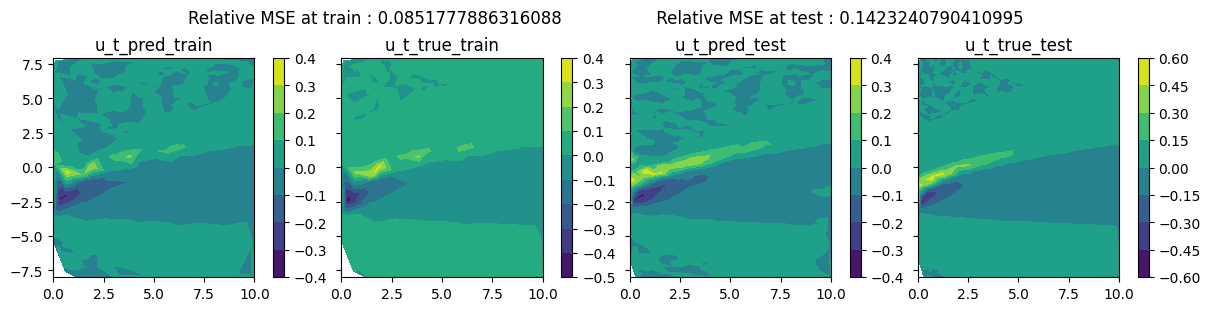

In [12]:
# u_t at training points and testing points
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 1, ncols=4 ,sharey= True, figsize = (12,3),constrained_layout=True)
n_mse_train = mean_squared_error(u_t_pred_train, u_t_train)/mean_squared_error(u_t_pred_train*0, u_t_train)
n_mse_test = mean_squared_error(u_t_pred_test, u_t_test)/mean_squared_error(u_t_pred_test*0, u_t_test)
fig.suptitle('Relative MSE at train : {}                  Relative MSE at test : {}'.format(round(n_mse_train,16),round(n_mse_test,16)))

# u_t at train
ax1plot = ax1.tricontourf(t_train, x_train, u_t_pred_train.flatten())
plt.colorbar(ax1plot, ax=ax1)
ax1.set_title('u_t_pred_train')
ax2plot = ax2.tricontourf(t_train, x_train, u_t_train.flatten())
plt.colorbar(ax2plot, ax=ax2)
ax2.set_title('u_t_true_train')

# u_t at test
ax3plot = ax3.tricontourf(t_test, x_test, u_t_pred_test.flatten())
plt.colorbar(ax3plot, ax=ax3)
ax3.set_title('u_t_pred_test')
ax4plot = ax4.tricontourf(t_test, x_test, u_t_test.flatten())
plt.colorbar(ax4plot, ax=ax4)
ax4.set_title('u_t_true_test')

plt.show()

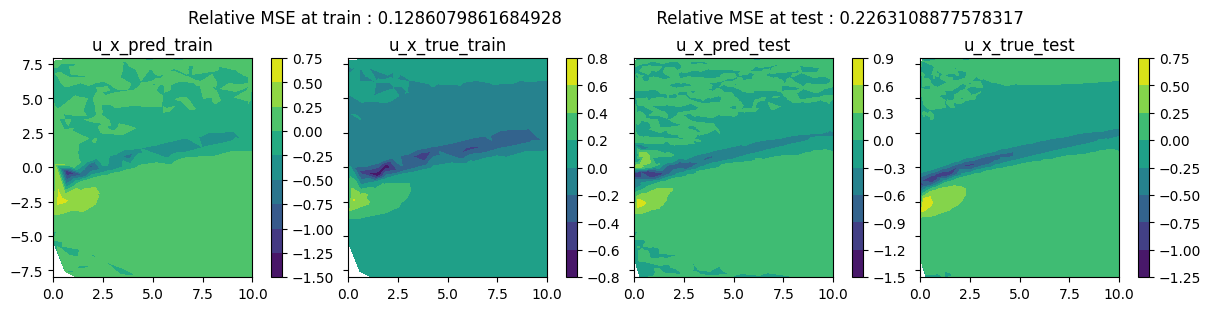

In [13]:
# u_x at training points and testing points
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 1, ncols=4 ,sharey= True, figsize = (12,3),constrained_layout=True)
n_mse_train = mean_squared_error(u_x_pred_train, u_x_train)/mean_squared_error(u_x_pred_train*0, u_x_train)
n_mse_test = mean_squared_error(u_x_pred_test, u_x_test)/mean_squared_error(u_x_pred_test*0, u_x_test)
fig.suptitle('Relative MSE at train : {}                  Relative MSE at test : {}'.format(round(n_mse_train,16),round(n_mse_test,16)))

# u_x at train
ax1plot = ax1.tricontourf(t_train, x_train, u_x_pred_train.flatten())
plt.colorbar(ax1plot, ax=ax1)
ax1.set_title('u_x_pred_train')
ax2plot = ax2.tricontourf(t_train, x_train, u_x_train.flatten())
plt.colorbar(ax2plot, ax=ax2)
ax2.set_title('u_x_true_train')

# u_x at test
ax3plot = ax3.tricontourf(t_test, x_test, u_x_pred_test.flatten())
plt.colorbar(ax3plot, ax=ax3)
ax3.set_title('u_x_pred_test')
ax4plot = ax4.tricontourf(t_test, x_test, u_x_test.flatten())
plt.colorbar(ax4plot, ax=ax4)
ax4.set_title('u_x_true_test')

plt.show()

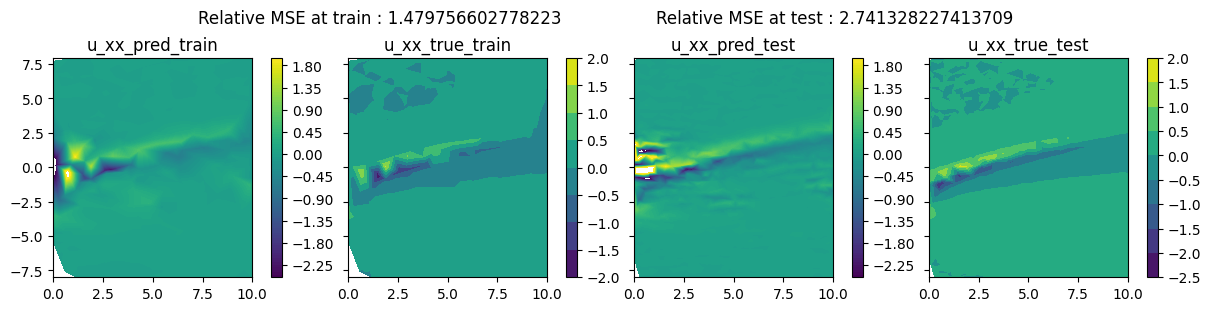

In [14]:
# u_xx at training points and testing points
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 1, ncols=4 ,sharey= True, figsize = (12,3),constrained_layout=True)
n_mse_train = mean_squared_error(u_xx_pred_train, u_xx_train)/mean_squared_error(u_xx_pred_train*0, u_xx_train)
n_mse_test = mean_squared_error(u_xx_pred_test, u_xx_test)/mean_squared_error(u_xx_pred_test*0, u_xx_test)
fig.suptitle('Relative MSE at train : {}                  Relative MSE at test : {}'.format(round(n_mse_train,16),round(n_mse_test,16)))

# u_xx at train
ax1plot = ax1.tricontourf(t_train, x_train, u_xx_pred_train.flatten(), levels = np.arange(-2.5,2,0.05))
plt.colorbar(ax1plot, ax=ax1)
ax1.set_title('u_xx_pred_train')
ax2plot = ax2.tricontourf(t_train, x_train, u_xx_train.flatten())
plt.colorbar(ax2plot, ax=ax2)
ax2.set_title('u_xx_true_train')

# u_xx at test
ax3plot = ax3.tricontourf(t_test, x_test, u_xx_pred_test.flatten(), levels = np.arange(-2.5,2,0.05))
plt.colorbar(ax3plot, ax=ax3)
ax3.set_title('u_xx_pred_test')
ax4plot = ax4.tricontourf(t_test, x_test, u_xx_test.flatten())
plt.colorbar(ax4plot, ax=ax4)
ax4.set_title('u_xx_true_test')

plt.show()

RKHSs norms squared $u^*$

In [15]:
rkhs_u = []
G = K_2D(Gaussian2D, X_train, X_train, optim_sgm_u)
G = G[:,:,0] + 1e-7*jnp.diag(jnp.diag(G[:,:,0])) # I had to regularize here (?)
alphas = np.linalg.solve(G, u_pred_train.flatten())
rkhs_u.append(np.dot(u_pred_train.flatten(),alphas))
# Print the norm
print('RKHS^2 norm of u^*: {}'.format(round(rkhs_u[0],2)))
# Save true values to be used in 1-step
two_step_dict['rkhs_u'] = rkhs_u

RKHS^2 norm of u^*: 14.04


We compute the norm of $u_*$ since it is more regular than $u$.

> Step 2: Learning $P$

In [16]:
s_train = np.hstack((X_train,u_train.T.reshape(-1,1),u_x_pred_train.T.reshape(-1,1),u_xx_pred_train.T.reshape(-1,1))) # 2000 * 5
s_test = np.hstack((X_test,u_test.T.reshape(-1,1),u_x_pred_test.T.reshape(-1,1),u_xx_pred_test.T.reshape(-1,1))) # 2000 * 5

f_train = u_t_train.T
f_test = u_t_test.T

scaler_s_train = MinMaxScaler()
s_train_s = scaler_s_train.fit_transform(s_train)
s_test_s = scaler_s_train.transform(s_test)

f_train2 = -s_train[:,2]*s_train[:,3] + 0.1*s_train[:,4]
f_test2 = -s_test[:,2]*s_test[:,3] + 0.1*s_test[:,4]

In [17]:
optim_sgm_P, optim_nugget_P = grid_search_RBF(s_train_s,f_train)
#optim_d_P, optim_nugget_P = 2, 1e-16
# Save true values to be used in one-step
two_step_dict['optim_sgm_P'] = optim_sgm_P
two_step_dict['optim_nugget_P'] = optim_nugget_P

krr_optimal_P = KernelRidge(kernel='rbf', alpha = optim_nugget_P, gamma=1/(2*(optim_sgm_P**2))) 
#krr_optimal_P = KernelRidge(kernel='poly', alpha = optim_nugget_P, degree = optim_d_P) 

krr_optimal_P.fit(s_train_s, f_train) 
f_pred_train = krr_optimal_P.predict(s_train_s) 
f_pred_train = f_pred_train.flatten() 
f_pred_test = krr_optimal_P.predict(s_test_s)
f_pred_test = f_pred_test.flatten() 

In [18]:
print('Optimal sigma of P^*:{}  Nugget of P^*: {:.2e}'.format(optim_sgm_P,optim_nugget_P))
#print('Degree for kernel of P^*:{}  Nugget of P^*: {:.2e}'.format(optim_d_P,optim_nugget_P))

Optimal sigma of P^*:0.8622462224614437  Nugget of P^*: 1.00e-08


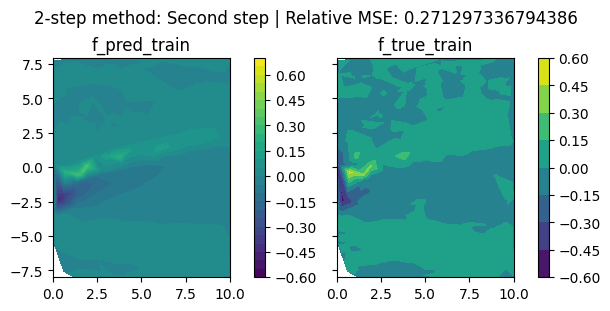

In [19]:
# Interpolant P^* at training points : P^*(hat S) vs. P(hat S)
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2 ,sharey= True, figsize = (6,3),constrained_layout=True)
n_mse = mean_squared_error(f_pred_train, f_train2)/mean_squared_error(f_pred_train*0, f_train2)
# u_t_train2 should be the estimation at the predicted input using the training collocation points and use the algebraic relation between the estimated gradients. 
fig.suptitle('2-step method: Second step | Relative MSE: {}'.format(round(n_mse,15)))
ax1plot = ax1.tricontourf(t_train, x_train, f_pred_train, levels = np.arange(-0.6,0.75,0.05))
plt.colorbar(ax1plot, ax=ax1)
ax1.set_title('f_pred_train')
ax2plot = ax2.tricontourf(t_train, x_train, f_train2)
plt.colorbar(ax2plot, ax=ax2)
ax2.set_title('f_true_train')

plt.show()

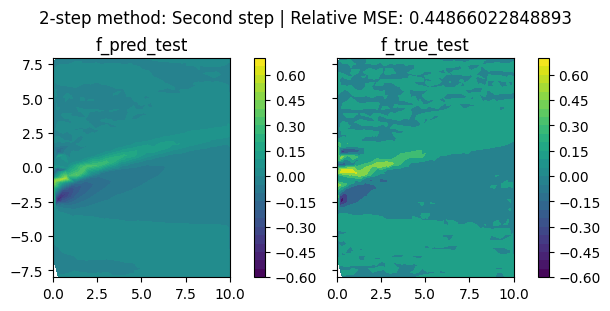

In [20]:
# Interpolant P^* at testing points
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2 ,sharey= True, figsize = (6,3),constrained_layout=True)
n_mse = mean_squared_error(f_pred_test, f_test2)/mean_squared_error(f_pred_test*0, f_test2)
fig.suptitle('2-step method: Second step | Relative MSE: {}'.format(round(n_mse,15)))
ax1plot = ax1.tricontourf(t_test, x_test, f_pred_test, levels = np.arange(-0.6,0.75,0.05))
plt.colorbar(ax1plot, ax=ax1)
ax1.set_title('f_pred_test')
ax2plot = ax2.tricontourf(t_test, x_test, f_test2)
plt.colorbar(ax1plot, ax=ax2)
ax2.set_title('f_true_test')

plt.show()

RKHS norm squared of $P^*$

In [21]:
# rkhs_P
nugget_P = 1e-7
G = K(Gaussian,s_train_s,s_train_s, optim_sgm_P) + nugget_P*np.eye(X_train.shape[0]) # added nugget here !
alphas_P = np.linalg.solve(G, f_pred_train)
rkhs_P_train = np.dot(f_pred_train, alphas_P)
print('RKHS^s norm of P^*: {}'.format(round(rkhs_P_train,2)))
# Save true values to be used in one-step
two_step_dict['rkhs_P_train'] = rkhs_P_train
two_step_dict['nugget_P'] = nugget_P

RKHS^s norm of P^*: 591.24


In [22]:
# rkhs_P
nugget_P = 1e-7
G_test = K(Gaussian,s_test_s,s_test_s, optim_sgm_P) + nugget_P*np.eye(X_test.shape[0]) # added nugget here !
alphas_P_test = np.linalg.solve(G_test, f_pred_test)
rkhs_P_test = np.dot(f_pred_test,alphas_P_test)
two_step_dict['rkhs_P_test'] = rkhs_P_test
print('RKHS^s norm of P^*: {}'.format(round(rkhs_P_test,2)))

RKHS^s norm of P^*: 995.04


In [23]:
two_step_dict['f_pred_test'] = f_pred_test

Test

> Compute std of feature 1 $\sigma_{\text{s[:,1]}}$ of `s_train` and perturb feature 1 of `s_train` using $m \sigma_{\text{s[:,1]}}$ each element. $m \in (0.01,0.25)$.

100%|██████████| 5/5 [26:50<00:00, 322.10s/it]


[[0.00307987 0.13285362 0.30589581 0.47842248 0.37091069]
 [0.00307987 0.2615827  0.53098458 0.22173562 0.31531827]
 [0.00307987 0.18088923 0.21308083 0.3051382  0.32314866]
 [0.00307987 0.11354046 0.21460885 0.27097627 0.43450826]
 [0.00307987 0.15066337 0.15752977 0.29815324 0.37374778]]


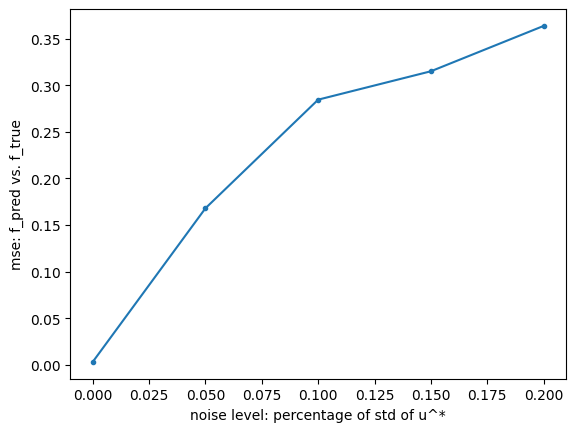

In [66]:
mses_P_all = []
for j in tqdm(range(5)):
    # Compute std per feature of s_train_s
    stds = np.std(s_train, axis = 0)
    beta = np.arange(0.0,0.25,0.05)
    scales = np.outer(beta, stds) 
    mses_P = []
    for i in tqdm(range(len(scales))):
        # Scales for current iteration
        scale = scales[i,:]
        # Copy s_train
        s_test = np.copy(s_train)
        # Perturb feature that contains u^* - Do this 10 times and average !!!
        s_test[:,2] = np.random.normal(s_train[:,2] , scale = scale[2])
        # Apply step one to perturbed u's 
        optim_sgm, alphas, optim_lmbd = kernel_parameters_Gaussian_2D(X_train, s_test[:,2].reshape(-1,1), e)
        _, _, u_x_pred, u_xx_pred = predictions_Burgers(X_train, X_train, Gaussian2D, optim_sgm, alphas, e , e)
        s_test[:,3] = u_x_pred.T.reshape(-1,1).flatten()
        s_test[:,4] = u_xx_pred.T.reshape(-1,1).flatten()
        # Scale the new s_test
        s_test_s = scaler_s_train.transform(s_test)
        # Compute predictions on test
        f_pred_test = krr_optimal_P.predict(s_test_s)
        # True test -> Why if I use this rule for s_test_s the bellow rule cannot be compared with f_pred_test
        f_true_test = -s_test[:,2]*s_test[:,3] + 0.1*s_test[:,4]
        # Compute mse per scale 
        mses_P.append(mean_squared_error(f_true_test,f_pred_test)/mean_squared_error(0*f_true_test,f_true_test))
# Plot - We have a vector of dimension 4 of scales vs. mses
    mses_P_all.append(mses_P)
mses_P_all = np.array(mses_P_all)
print(mses_P_all)
mean_mses_P_all = np.mean(mses_P_all, axis = 0)
plt.plot(beta,mean_mses_P_all,'.-')
plt.xlabel('noise level: percentage of std of u^*')
plt.ylabel('mse: f_pred vs. f_true')
plt.show()

In [24]:
np.save('data/two_step_dict.npy',two_step_dict)